In [1]:
# basic libraries and functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#
import pickle
#
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#
#
SAVE = lambda data, dir, name: pickle.dump(data, open(dir + name + ".pkl", "wb"))   # save file
LOAD = lambda file:            pickle.load(open(file + ".pkl", "rb"))               # read file

In [2]:
# read if file exists
def TRY_LOAD(file):
    try:
        data = LOAD(file)
        return data
    except:
        return 0
        #
    #####
    #
#####

In [3]:
# basic paths
ORIGIN = "original_features"                                         # original features
DER_1  = "der_features_hypothesis_1"                                 # derived features: ver. 1
DER_2  = "der_features_hypothesis_2"                                 # derived features: ver. 2
#
correlations_dir = "b_correlations/"                                 # directory of "find_correlations" outputs
fitted_model_all = "a_fitted_model/all_dataset/"                     # directory of "RandomForestClassifier" outputs (using all dataset)
fitted_model_par = "a_fitted_model/partial_dataset/"                 # directory of "RandomForestClassifier" outputs (with partial dataset)
gini_impurities  = "c_gini_impurities/"                              # directory of "Feature_Importances" outputes (1/10 of dataset)
#
#
fitted_all_original_features  = TRY_LOAD(fitted_model_all + ORIGIN)  # random forest weights (for all original dataset)
fitted_all_der_features_hyp_1 = TRY_LOAD(fitted_model_all + DER_1)   # random forest weights (for all der. ver. 1 dataset)
fitted_all_der_features_hyp_2 = TRY_LOAD(fitted_model_all + DER_2)   # random forest weights (for all der. ver. 2 dataset)
#
#
original_features_correlation = TRY_LOAD(correlations_dir + ORIGIN)  # correlation study (for all original dataset)
derived_features_correlation  = TRY_LOAD(correlations_dir + DER_1)   # correlation study (for all der. ver. 1 dataset)
#
#
gini_impurities_of_original   = TRY_LOAD(gini_impurities + ORIGIN)   # gini impurities among original features
#                                                                    # (average among many realizations of 1/10 of dataset)
gini_impurities_of_derived_1  = TRY_LOAD(gini_impurities + DER_1)    # gini impurities among derived features (same)

In [6]:
# reading original features
def make_df(dir, file):
    df     = pd.DataFrame()
    df_tmp = pd.read_csv("data/" + dir + "/" + file, delimiter = " ", skiprows = 2)
    #
    df["ALPHA"] = 0                                # associated with the efficiency of common envelope
    df["METAL"] = 0                                # stellar metallicity at which the black holes where produced
    df["MST1"]  = df_tmp["col.1:m1ZAMS/Msun"]      # ZAMS mass of the primary member of the binary system (BS) [Msun]
    df["MST2"]  = df_tmp["col.2:m2ZAMS/Msun"]      # ZAMS mass of the secondary member of the BS [Msun]
    df["MBH1"]  = df_tmp["col.3:m1rem/Msun"]       # mass of the black hole (BH) from the primary member [Msun]
    df["MBH2"]  = df_tmp["col.4:m2rem/Msun"]       # mass of the BH from the secondary member [Msun]
    df["TIME"]  = df_tmp["col.6:delay_time/Myr"]   # time from the formation of the BS to the merger of the two BH [Myr]
    df["AXIS"]  = df_tmp["col.7:sma/Rsun"]         # semi-major axis of the BS at the formation of the second-born BH [Rsun] 
    df["ECCE"]  = df_tmp["col.8:ecc"]              # orbital eccentricity of the BS at the formation of the second-born BH
    df["ISCE"]  = df_tmp["col.21:CE"]              # True: the BS undergoes a common envelope. False: the BS goes via stable mass transfer
    df["ALPHA"] = np.float64(dir[1:])
    df["METAL"] = np.float64(file.split("_")[-1].split(".txt")[0])
    del df_tmp
    return df
    #
#####

In [9]:
# making derived features [HYPOTHESIS 1]
def make_der_df(df):
    df_der = pd.DataFrame()
    df_der["ALPHA"]           = df["ALPHA"]
    df_der["METAL"]           = df["METAL"]
    df_der["MS_TOT"]          = df["MST2"] + df["MST1"]                                # MST2+MST1
    df_der["MS_RATIO"]        = df["MST2"] / df["MST1"]                                # MST2/MST1
    df_der["M_LOSS"]          = 1 - ((df["MBH2"] + df["MBH1"]) / df_der["MS_TOT"])     # 1-[(MBH2+MBH1)/(MST2+MST1)]
    df_der["M_RATIO_LOSS"]    = 1 - ((df["MBH2"] / df["MBH1"]) / df_der["MS_RATIO"])   # 1-[(MBH2/MBH1)/(MST2/MST1)]
    df_der["INITIAL_DENSITY"] = df_der["MS_TOT"] / (df["AXIS"] ** 2)                   # (MST2+MST1)/(AXIS^2)
    df_der["ISCE"]            = df["ISCE"]
    return df_der
    #
#####

In [11]:
def making_plot(columns, values, title, xlabel, ylabel):
    plt.figure(figsize = (10, 6))
    plt.bar(columns, values, color = 'skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation = 45)
    plt.show()
    #
#####

In [13]:
# reading original features
df = [make_df(dir, file) for dir in os.listdir("data") for file in os.listdir("data/" + dir)]
df = pd.concat(df, ignore_index = True)
#
# making derived features
df_der = make_der_df(df)
#
#
# columns
# [ORIGINAL FEATURES]
original_columns   = ["ALPHA", "METAL", "MST1", "MST2", "MBH1", "MBH2", "TIME", "AXIS", "ECCE"]
#
# [DERIVED FEATURES - HYPOTHESIS 1]
der_hypo_1_columns = df_der.columns[:-1]
#
# [DERIVED FEATURES - HYPOTHESIS 2]
der_hypo_2_columns = ["ALPHA",             # as hyp 1
                      "METAL",             # as hyp 1
                      "MS_TOT",            # as hyp 1
                      "MS_RATIO",          # as hyp 1
                      "MS_RATIO_INV",      # MS_RATIO ** (-1)
                      "MBH_RATIO",         # MBH2 / MBH1
                      "M_LOSS",            # as hyp 1
                      "M_RATIO_LOSS",      # as hyp 1
                      "INITIAL_DENSITY"]   # as hyp 1
#
#
# original features
x0 = df[original_columns]
y0 = df["ISCE"]
#
# derived features
x1 = df_der[der_hypo_1_columns]
y1 = df_der["ISCE"]

In [14]:
df

,ALPHA,METAL,MST1,MST2,MBH1,MBH2,TIME,AXIS,ECCE,ISCE
0,0.5,0.0002,24.1323,17.1893,9.5692,5.0020,141.1783,5.1703,0.258940,True
1,0.5,0.0002,69.5474,64.3689,28.4847,39.1186,9.2023,6.4328,0.055966,True
2,0.5,0.0002,106.6977,41.0318,39.9392,38.2094,2223.2639,35.8880,0.041435,False
3,0.5,0.0002,74.3594,54.3256,30.1523,37.4020,8.7628,6.0720,0.041342,True
4,0.5,0.0002,116.6000,63.2642,41.9604,42.9817,2636.2197,40.0410,0.079504,False
...,...,...,...,...,...,...,...,...,...,...
2963577,5.0,0.0080,48.9573,19.7100,10.8926,5.9585,7756.0107,294.0700,0.985010,True
2963578,5.0,0.0080,34.5546,16.8936,6.3492,4.2247,1695.1692,145.9600,0.986440,True
2963579,5.0,0.0080,69.2348,68.4813,15.7625,15.2704,5835.8062,22.8700,0.010585,True
2963580,5.0,0.0080,47.0333,44.4414,10.9537,12.5890,90.3961,6.6481,0.187760,True


In [15]:
df.describe().iloc[[1, 2, 3, 7]].T

,mean,std,min,max
ALPHA,2.332700,1.678982,0.500000,5.0000
METAL,0.000973,0.000991,0.000200,0.0200
MST1,47.322197,23.121194,17.311500,149.9961
MST2,30.189191,16.999242,7.379700,149.4476
MBH1,15.590751,9.615171,3.000000,69.2366
MBH2,18.575979,10.363684,3.000000,45.4382
TIME,2418.260219,3360.383274,4.328600,13999.9219
AXIS,17.085039,301.758136,0.664170,329100.0000
ECCE,0.113345,0.171247,0.000004,1.0000


In [16]:
df_der

,ALPHA,METAL,MS_TOT,MS_RATIO,M_LOSS,M_RATIO_LOSS,INITIAL_DENSITY,ISCE
0,0.5,0.0002,41.3216,0.712294,0.647371,0.266148,1.545773,True
1,0.5,0.0002,133.9163,0.925540,0.495182,-0.483804,3.236185,True
2,0.5,0.0002,147.7295,0.384561,0.471002,-1.487742,0.114701,False
3,0.5,0.0002,128.6850,0.730581,0.475041,-0.697875,3.490313,True
4,0.5,0.0002,179.8642,0.542575,0.527743,-0.887924,0.112185,False
...,...,...,...,...,...,...,...,...
2963577,5.0,0.0080,68.6673,0.402596,0.754598,-0.358740,0.000794,True
2963578,5.0,0.0080,51.4482,0.488896,0.794475,-0.361008,0.002415,True
2963579,5.0,0.0080,137.7161,0.989117,0.774660,0.020560,0.263301,True
2963580,5.0,0.0080,91.4747,0.944892,0.742632,-0.216321,2.069693,True


In [17]:
df_der.describe().iloc[[1, 2, 3, 7]].T

,mean,std,min,max
ALPHA,2.332700,1.678982,5.000000e-01,5.000000
METAL,0.000973,0.000991,2.000000e-04,0.020000
MS_TOT,77.511388,38.173438,2.802710e+01,299.335600
MS_RATIO,0.646669,0.186271,1.538630e-01,1.000000
M_LOSS,0.580321,0.097071,6.736397e-02,0.928978
M_RATIO_LOSS,-1.062644,0.519849,-2.864401e+01,0.870480
INITIAL_DENSITY,1.145268,3.909293,9.080869e-10,137.960082


In [18]:
def find_correlations(df_in, name, save = False):
    #
    ALPHA    = [0.5, 1, 3, 5]
    METAL    = [0.0002, 0.0004, 0.0008, 0.0012, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.012, 0.016, 0.02]
    features = list(df_in.columns)[:-1]
    #
    #
    def find_scale_in_base_2(range):
        scale = 0
        while (range / (2 ** scale)) > 1: scale += 1
        return scale + 2
        #
    #####
    #
    #
    def find_new_range(MIN, MAX, TH):
        average = (MIN + MAX) / 2
        if TH > average:
            new_MIN = average
            new_MAX = MAX
        else:
            new_MIN = MIN
            new_MAX = average
            #
        #####
        #
        return new_MIN, new_MAX
        #
    #####
    #
    #
    def evaluate_th(df, ft, TH, is_major, best, th_best):
        df["BOOL"]  = (df[ft] > TH) if is_major else (df[ft] < TH)
        df["IP"]    = ((df["BOOL"] & df["ISCE"]) | ((~ df["BOOL"]) & (~ df["ISCE"]))).astype(int)
        esit        = (df["IP"].sum() / df["IP"].size)
        if best     < esit:
            best    = esit
            th_best = TH
            #
        #####
        #
        return th_best, best
        #
    #####
    #
    #
    def find_best_th(df, ths, ft):
        best_1, th_best_1 = 0, 0
        best_2, th_best_2 = 0, 0
        best,   th_max    = 0, 0
        is_major          = True
        #
        for TH in ths:
            th_best_1, best_1 = evaluate_th(df, ft, TH, True,  best_1, th_best_1)
            th_best_2, best_2 = evaluate_th(df, ft, TH, False, best_2, th_best_2)
            #
        #####
        #
        if best_1 > best_2:
            best, th_max = best_1, th_best_1
        else:
            best, th_max = best_2, th_best_2
            is_major     = False
            #
        #####
        #
        return best, th_max, is_major
        #
    #####
    #
    #
    def find_best_points(df_tmp, ft, save = False):
        result = []
        for i in ALPHA:
            for j in METAL:
                df       = df_tmp[(df_tmp["ALPHA"] == i) & (df_tmp["METAL"] == j)][[ft, "ISCE"]]
                progress = ((int((((len(METAL) * ALPHA.index(i)) + METAL.index(j)) / (len(ALPHA) * len(METAL))) * 1000)) / 10)
                print("feature: ", ft, " progress: ", progress, "%")
                #
                MIN      = df[ft].min()
                MAX      = df[ft].max()
                scale    = find_scale_in_base_2(MAX / MIN)
                ths      = np.linspace(MIN, MAX, 100)
                #
                best, TH, is_major      = find_best_th(df, ths, ft)
                for w in range(scale):
                    number_of_points    = int(50 + (50 * (w/scale)))
                    MIN, MAX            = find_new_range(MIN, MAX, TH)
                    ths                 = np.linspace(MIN, MAX, number_of_points)
                    best, TH, is_major  = find_best_th(df_tmp, ths, ft)
                    #
                #####
                #
                result_row = [i, j, TH, is_major, best]
                result    += [result_row]
                del df
                #
            #####
            #
        #####
        #
        result            = pd.DataFrame(np.array(result))
        result["feature"] = ft
        #
        return result
        #
    #####
    #
    result = [find_best_points(df_in, feature, save) for feature in features]
    df     = pd.concat(result, ignore_index = True)
    #
    if save:
        SAVE(result, correlations_dir, name)
    else:
        return df
        #
    #####
    #
#####
#
#
# runs
# if isinstance(original_features_correlation, int): find_correlations(df, ORIGIN, save = True)
if isinstance(derived_features_correlation, int): find_correlations(df, DER_1,  save = True)

In [19]:
# shows results
for ft in der_hypo_1_columns[2:]:
    df_tmp = derived_features_correlation[derived_features_correlation["feature"] == ft]
    df_tmp = df_tmp.describe().iloc[[1, 2, 3, 7]].T
    print(ft)
    print(df_tmp)
    print("\n")

MS_TOT
                   mean         std        min         max
ALPHA          2.375000    1.799823   0.500000    5.000000
METAL          0.006017    0.006461   0.000200    0.020000
TH           125.064506  109.266876  28.372100  299.289384
is_major       0.500000    0.505291   0.000000    1.000000
PREDIC. [%]    0.852963    0.014328   0.778529    0.860783


MS_RATIO
                 mean       std       min       max
ALPHA        2.375000  1.799823  0.500000  5.000000
METAL        0.006017  0.006461  0.000200  0.020000
TH           0.485288  0.265261  0.349896  0.999973
is_major     0.791667  0.410414  0.000000  1.000000
PREDIC. [%]  0.862387  0.004079  0.839959  0.863740


M_LOSS
                 mean       std       min       max
ALPHA        2.375000  1.799823  0.500000  5.000000
METAL        0.006017  0.006461  0.000200  0.020000
TH           0.638428  0.193136  0.462377  0.913412
is_major     0.541667  0.503534  0.000000  1.000000
PREDIC. [%]  0.859879  0.043813  0.716097  0.88

In [39]:
# first fitting with all features and 100 tree estimators
def fitting_all_features(x, y, dir, name):
    model = RandomForestClassifier(n_estimators             = 100,     # The number of trees in the forest;
                                   criterion                = 'gini',  # The function to measure the quality of a split
                                                                       # {"gini", "entropy", "log_loss"};
                                   max_depth                = None,    # The maximum depth of the tree;
                                   min_samples_split        = 2,       # The minimum number of samples required to split an internal node;
                                   min_samples_leaf         = 1,       # The minimum number of samples required to be at a leaf node;
                                   min_weight_fraction_leaf = 0.0,     # The minimum weighted fraction of the sum total of weights
                                                                       # (of all the input samples) required to be at a leaf node;
                                   max_features             = 'sqrt',  # The number of features to consider when looking for the best split
                                                                       # {"sqrt", "log2", None} | int
                                                                       # max_features = sqrt(n_features) | log2(n_features) | n_features;
                                   max_leaf_nodes           = None,    # If None then unlimited number of leaf nodes;
                                   min_impurity_decrease    = 0.0,     # If this split induces a decrease of the impurity >=
                                                                       # then that node will be splitted;
                                   bootstrap                = True,    # If False, the whole dataset is used to build each tree;
                                   oob_score                = False,   # If to use out-of-bag samples to estimate the generalization score;
                                   n_jobs                   = -1,      # The number of jobs to run in parallel
                                                                       # "-1" means using all processors;
                                   random_state             = 42,      # Used for reproducibility;
                                   verbose                  = 0,       # Controls the verbosity when fitting and predicting;
                                   warm_start               = False,   # if True reuse solution of previous call to add more estimators;
                                   class_weight             = None,    # dict of Weights associated with features;
                                   ccp_alpha                = 0.0,     # The subtree with the largest cost complexity that is smaller
                                                                       # than this will be chosen;
                                   max_samples              = None,    # If bootstrap is True, it is the number of samples to draw from X;
                                   monotonic_cst            = None)    # If is None then no constraints are applied;
    model.fit(x, y)
    SAVE(model, dir, name)
    del model
    #
#####
#
# runs
if isinstance(fitted_all_original_features , int): fitting_all_features(x0, y0, fitted_model_all, ORIGIN)
if isinstance(fitted_all_der_features_hyp_1, int): fitting_all_features(x1, y1, fitted_model_all, DER_1)
if isinstance(fitted_all_der_features_hyp_2, int): fitting_all_features(x2, y2, fitted_model_all, DER_2)

In [29]:
# makes data for plotting
all_orig_weight  = pd.DataFrame(fitted_all_original_features.feature_importances_,  original_columns).T
all_der_1_weight = pd.DataFrame(fitted_all_der_features_hyp_1.feature_importances_, der_hypo_1_columns).T
all_der_2_weight = pd.DataFrame(fitted_all_der_features_hyp_2.feature_importances_, der_hypo_2_columns).T

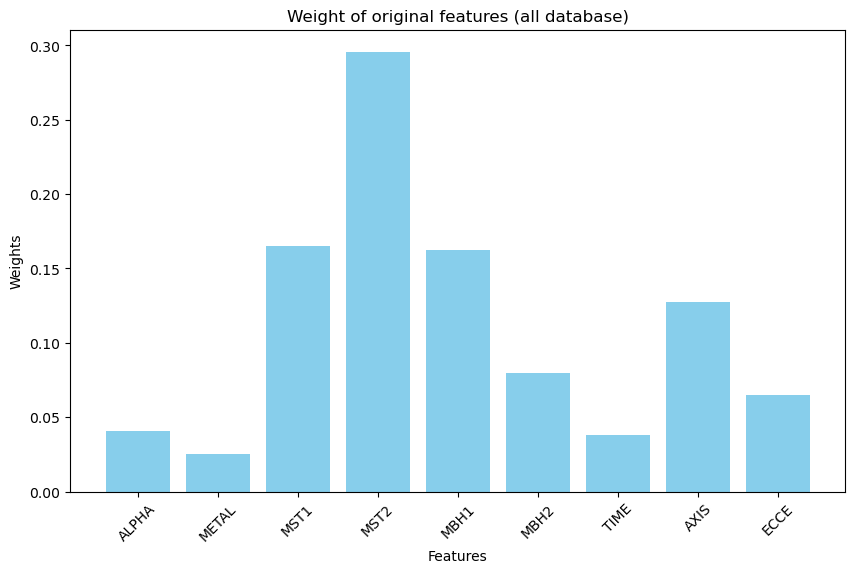

,ALPHA,METAL,MST1,MST2,MBH1,MBH2,TIME,AXIS,ECCE
0,0.040853,0.02555,0.165359,0.295784,0.162506,0.079824,0.037883,0.127419,0.064821


In [31]:
making_plot(columns = all_orig_weight.columns,
            values  = all_orig_weight.iloc[0],
            title   = "Weight of original features (all database)",
            xlabel  = "Features",
            ylabel  = "Weights")
#
all_orig_weight

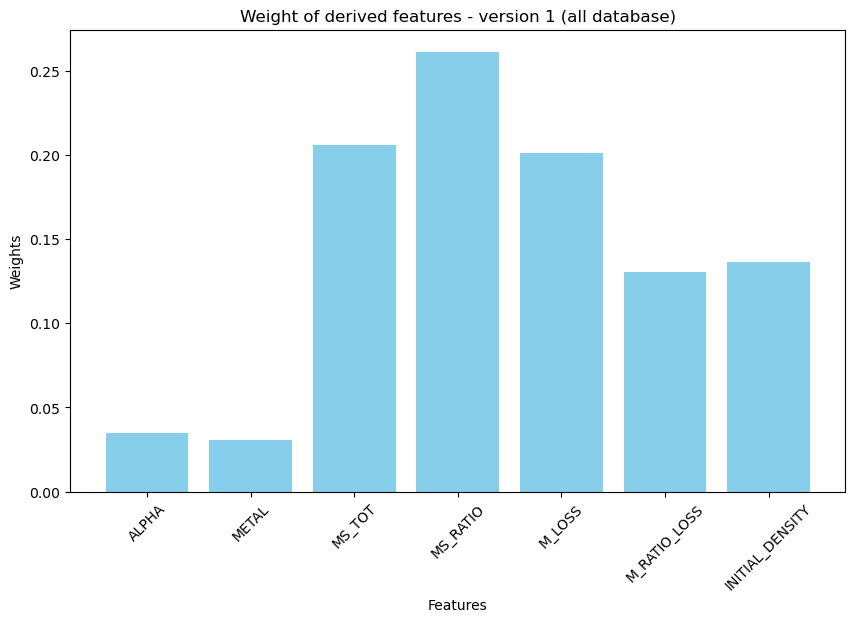

,ALPHA,METAL,MS_TOT,MS_RATIO,M_LOSS,M_RATIO_LOSS,INITIAL_DENSITY
0,0.03457,0.030893,0.205553,0.261253,0.201115,0.130503,0.136113


In [33]:
making_plot(columns = all_der_1_weight.columns,
            values  = all_der_1_weight.iloc[0],
            title   = "Weight of derived features - version 1 (all database)",
            xlabel  = "Features",
            ylabel  = "Weights")
#
all_der_1_weight

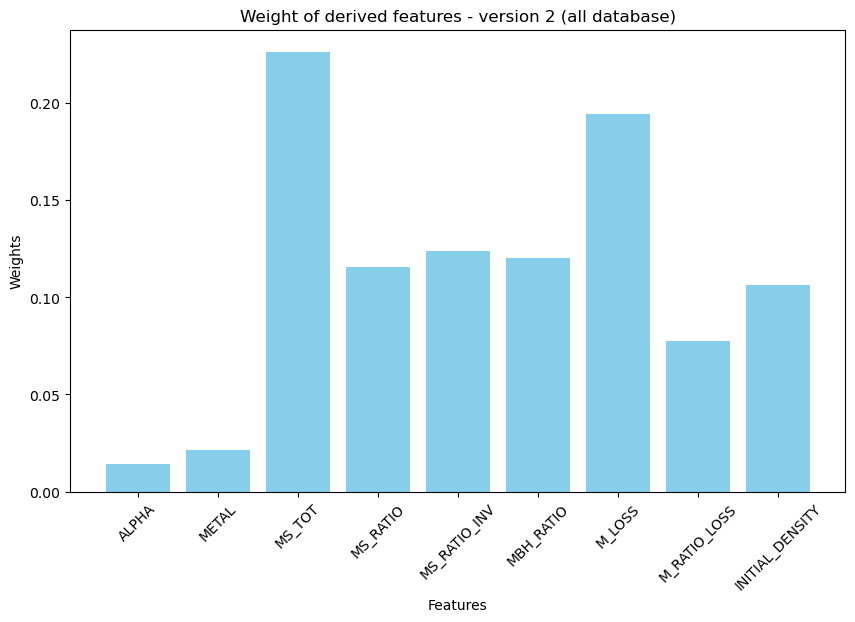

,ALPHA,METAL,MS_TOT,MS_RATIO,MS_RATIO_INV,MBH_RATIO,M_LOSS,M_RATIO_LOSS,INITIAL_DENSITY
0,0.01434,0.021386,0.226502,0.115449,0.123795,0.12031,0.194473,0.077308,0.106437


In [35]:
making_plot(columns = all_der_2_weight.columns,
            values  = all_der_2_weight.iloc[0],
            title   = "Weight of derived features - version 2 (all database)",
            xlabel  = "Features",
            ylabel  = "Weights")
#
all_der_2_weight

In [37]:
class Feature_Importances:
    def __init__(self, x, y):
        # select 1/8 of the dataset
        x["CHOICE"] = np.random.randint(0, 8, x.shape[0])
        x           = x[x["CHOICE"] == 0]
        x           = x[x.columns[:-1]]
        y           = y.iloc[x.index]
        #
        self.x          = x
        self.y          = y
        self.x_columns  = list(x.columns)
        self.index      = x.index
        self.n_rows     = x.shape[0]
        self.n_columns  = x.shape[1]
        self.impurities = None
        #
    #####
    #
    def cellular_gini(self, index, column):
        if ((index % 5000) == 0): print(column, "progress: ", int((index / self.n_rows) * 10e5) / 10e3, "%")
        root_node = pd.DataFrame(np.zeros((3, 2)), index = ["True", "False", "Sums"], columns = ["<", ">"])
        #
        root_node.loc["True",  "<"] =    self.y[ :index].astype(int).sum()
        root_node.loc["False", "<"] = (~ self.y[ :index]).astype(int).sum()
        root_node.loc["True",  ">"] =    self.y[index: ].astype(int).sum()
        root_node.loc["False", ">"] = (~ self.y[index: ]).astype(int).sum()
        root_node.loc["Sums",  "<"] = root_node.sum(axis = 0)["<"]
        root_node.loc["Sums",  ">"] = root_node.sum(axis = 0)[">"]
        #
        D_m = root_node.loc["Sums",  "<"]
        D_M = root_node.loc["Sums",  ">"]
        D   = root_node.sum(axis = 1)["Sums"]
        #
        leaf_m   = 1 - ((root_node.loc["True",  "<"] / D_m) ** 2) - ((root_node.loc["False",  "<"] / D_m) ** 2)
        leaf_M   = 1 - ((root_node.loc["True",  ">"] / D_M) ** 2) - ((root_node.loc["False",  ">"] / D_M) ** 2)
        impurity = ((D_m / D) * leaf_m) + ((D_M / D) * leaf_M)
        #
        return impurity
        #
    #####
    #
    def evaluate_column(self, column):
        self.x = self.x.sort_values(by = column, ascending = True)
        self.y = self.y.loc[self.x.index]
        #
        gini_impurities = [self.cellular_gini(index, column) for index in list(range(self.n_rows))[1:]]
        MIN             = min(gini_impurities)
        index           = gini_impurities.index(MIN)
        th              = (self.x[column].iloc[index] + self.x[column].iloc[index + 1]) / 2
        #
        self.x = self.x.loc[self.index]
        self.y = self.y.loc[self.index]
        #
        impurity        = pd.DataFrame([[MIN, th]], index = [column], columns = ["gini", "th"])
        self.impurities = pd.concat([self.impurities, impurity], ignore_index = False)
        #
    #####
    #
    def evaluate_gini(self):
        _ = [self.evaluate_column(column) for column in self.x_columns]
        #
    #####
    #
#####
#
#

In [ ]:
# run the code
if isinstance(gini_impurities_of_original, int):
    gini_impurities_of_original = Feature_Importances(x0, y0)    # evaluate the gini impurities for a random selection of 1/10 of dataset
    gini_impurities_of_original.evaluate_gini()
    SAVE(gini_impurities_of_original, gini_impurities, ORIGIN)
    #
#####
if isinstance(gini_impurities_of_derived_1, int):
    gini_impurities_of_derived_1 = Feature_Importances(x0, y0)   # the same for the derived features
    gini_impurities_of_derived_1.evaluate_gini()
    SAVE(gini_impurities_of_derived_1, gini_impurities, DER_1)
    #
#####
#

In [ ]:
making_plot(columns = gini_impurities_of_original.impurities.index,
            values  = gini_impurities_of_original.impurities["gini"],
            title   = "Gini impurities of initial features",
            xlabel  = "Features",
            ylabel  = "impurities")

In [ ]:
making_plot(columns = gini_impurities_of_derived_1.impurities.index,
            values  = gini_impurities_of_derived_1.impurities["gini"],
            title   = "Gini impurities of derived features",
            xlabel  = "Features",
            ylabel  = "impurities")